In [3]:
#Import Dependecies

import warnings
warnings.filterwarnings('ignore')

#PER
from Memory import *


# Keras and TF
import keras.backend.tensorflow_backend as backend
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten, concatenate
from keras.layers.normalization import BatchNormalization

from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard

import tensorflow as tf

#Misc
from collections import deque
import time
from datetime import datetime
import random
from tqdm import tqdm

import os, sys
os.environ['CUDA_DEVICE_ORDER'] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""

import random 
import numpy as np
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
import pickle

#SUMO TraCI
import traci




Using TensorFlow backend.


In [5]:
#Get Multiple types of states : 

def get_state(intersection, state_type ='n_of_vehicles', edge_length=750, max_pos=250, in_out=False,\
              get_reward=False, ignore_far_cars=False):
    '''
    Retrieve Different Types of states specified by state_type,
    Default: n_of_vehicles. specify the horizon of detection by max_pos.
    choose from: queue, waiting_time, throughput, queue_in_out, throughput, speed, fuel_consumption.
    Output: Vector including lane states, and current phase state [0,1,2,3]. 
    '''
    # retrieve incoming lanes list of the traffic light 
    lanes_list = list(traci.trafficlight.getControlledLanes(intersection))
    # Outgoing list from the intersection
    out_list = [lane.replace('in','out') for lane in lanes_list]
    if in_out:
        lanes_list+= out_list
    N = len(lanes_list) 
    state = np.zeros((N+1 ,1), dtype=np.int32)
    
    # Troughput
    if state_type == 'throughput':
        for i,lane in enumerate(out_list): 
            veh_count = 0
            for vehicle in traci.lane.getLastStepVehicleIDs(lane): # loop over vehicles in lane

                veh_pos = traci.vehicle.getLanePosition(vehicle) # get vehicle's position
                if veh_pos <max_pos:
                    veh_count+=1
            state[i] = veh_count
      
    #Queue In and throughput
    elif state_type == 'queue_in_out':
        N = len(lanes_list) + len(out_list)
        state = np.zeros((N+1, 1), dtype=np.int32)
        
        for i,lane in enumerate(lanes_list):
            
#             lane_state = traci.lane.getLastStepHaltingNumber(lanes_list[i])
#             state[i] = lane_state
            veh_count=0
            for vehicle in traci.lane.getLastStepVehicleIDs(lane):
                veh_pos = (edge_length-17) - np.abs(int(traci.vehicle.getLanePosition(vehicle)))
                if veh_pos <max_pos:
                    veh_count+=1
            state[i] = veh_count
            
            
        
        for i,lane in enumerate(out_list): 
            veh_count = 0
            for vehicle in traci.lane.getLastStepVehicleIDs(lane):

                veh_pos = traci.vehicle.getLanePosition(vehicle)
                if veh_pos <max_pos:
                    veh_count+=1
            state[i+len(lanes_list)] = veh_count
        
        
            
    else:
#         car_list = traci.vehicle.getIDList()
        for i,lane in enumerate(lanes_list):
            
            # queue state
            if state_type == 'queue':
                lane_state = traci.lane.getLastStepHaltingNumber(lanes_list[i])#get number of Queuing/
                                                                            #halting vehicles on lane
                state[i] = lane_state
           
            
            #waiting time state 
            elif state_type == 'waiting_time':
                lane_state = traci.lane.getWaitingTime(lanes_list[i]) # get waiting vehicles on lane
                
                state[i] = lane_state
            # Alternative waiting time state 
            elif state_type == 'waiting_time_2':
                lane_state = 0

                for car_id in traci.lane.getLastStepVehicleIDs(lane):# loop over vehicle iDs in lane
                    wait_time = traci.vehicle.getWaitingTime(car_id) # get waiting time of the vehicle
                    lane_id = traci.vehicle.getLaneID(car_id)  # lane id of the car
                    if lane_id == lane:  # add waiting time of vehicles to the corresponding lane.
                        lane_state += wait_time
                
                state[i] = lane_state
            
            
            # Speed state
            elif state_type == 'speed':  
                lane_state = traci.lane.getLastStepMeanSpeed(lanes_list[i]) # Get average speed of vehicles
                                                                            # on the given lane
                state[i] = lane_state
            
            # Alternative waiting time state
            elif state_type == 'n_of_vehicles_2':                
                    for car_id in traci.lane.getLastStepVehicleIDs(lane):
                        lane_id = traci.vehicle.getLaneID(car_id)
                        if lane_id == lane:  
                            state[i] += 1
            # Alternative waiting time state
            elif state_type == 'n_of_vehicles_3':
                lane_state = traci.lane.getLastStepVehicleNumber(lanes_list[i])
                state[i] = lane_state
            
            # Fuel consumption
            elif state_type == 'fuel_consumption':
                lane_state = traci.lane.getFuelConsumption(lanes_list[i])
                state[i] = lane_state
                
            #else Number of Vehicles State. Default Choice
            else:

                lane_state = traci.lane.getLastStepVehicleNumber(lanes_list[i])

                lane_approach = 0
                veh_count = 0
                for vehicle in traci.lane.getLastStepVehicleIDs(lane):

                    if lane not in out_list:

                        veh_pos = (edge_length-17) - np.abs(int(traci.vehicle.getLanePosition(vehicle)))
                        if veh_pos<7:
                            lane_approach=1

                        if veh_pos <max_pos: #limit the horizon of detection starting from the intersection


                            veh_count+=1

#                     if lane in out_list:
#                         veh_pos = traci.vehicle.getLanePosition(vehicle)
#                         if veh_pos <max_pos:
#                             veh_count+=1

                if ignore_far_cars:
                    lane_approach = lane_approach
                else:
                    lane_approach = 1

                if lane_approach:
                    state[i] = veh_count
   
    # if retrieving just the reward value, not state vector.
    if get_reward:
        reward = np.sum(np.array(state))
        return reward
    #else, we proceed with adding the state current phase to the state vector
    else:
        all_phases = traci.trafficlight.getAllProgramLogics(intersection) # get all phases codings from
                                                                            #traffic light control id
        current_phase = traci.trafficlight.getRedYellowGreenState(intersection) # get the current phase of signals
    
        # Encode the current phase to either 0 or 1 or 2 or 3
        for i,phase in enumerate(all_phases[0].getPhases()):
            s = phase.__repr__().split(',')
            s = s[1].split('\'')[1]

            if current_phase == s:
                state[N] = np.floor(i/2)

        return state

In [6]:
#state DTSE

def get_state_DTSE_2(intersection='intersection'):
    """
    Retrieve DTSE of the intersection from sumo, in the form of cell occupancy
    credits to Andrea Vidali, Wade Genders
    """
    N = 80 
    state = np.zeros(N+1)
    car_list = traci.vehicle.getIDList()

    for car_id in car_list:
        lane_pos = traci.vehicle.getLanePosition(car_id)
        lane_id = traci.vehicle.getLaneID(car_id)
        lane_pos = 750 - lane_pos  # inversion of lane pos, so if the car is close to the traffic light -> lane_pos = 0 --- 750 = max len of a road

        # distance in meters from the traffic light -> mapping into cells

         
        if lane_pos < 7:
            lane_cell = 0
        elif lane_pos < 14:
            lane_cell = 1
        elif lane_pos < 21:
            lane_cell = 2
        elif lane_pos < 28:
            lane_cell = 3
        elif lane_pos < 40:
            lane_cell = 4
        elif lane_pos < 60:
            lane_cell = 5
        elif lane_pos < 100:
            lane_cell = 6
        elif lane_pos < 160:
            lane_cell = 7
        elif lane_pos < 400:
            lane_cell = 8
        elif lane_pos <= 750:
            lane_cell = 9

        # finding the lane where the car is located 
        # x2TL_3 are the "turn left only" lanes

        if lane_id == "e1_in_0" or lane_id == "e1_in_1" or lane_id == "e1_in_2":
            lane_group = 0
        elif lane_id == "e1_in_3":
            lane_group = 1
        elif lane_id == "e4_in_0" or lane_id == "e4_in_1" or lane_id == "e4_in_2":
            lane_group = 2
        elif lane_id == "e4_in_3":
            lane_group = 3
        elif lane_id == "e3_in_0" or lane_id == "e3_in_1" or lane_id == "e3_in_2":
            lane_group = 4
        elif lane_id == "e3_in_3":
            lane_group = 5
        elif lane_id == "e2_in_0" or lane_id == "e2_in_1" or lane_id == "e2_in_2":
            lane_group = 6
        elif lane_id == "e2_in_3":
            lane_group = 7
        else:
            lane_group = -1

        if lane_group >= 1 and lane_group <= 7:
            car_position = int(str(lane_group) + str(lane_cell))  # composition of the two postion ID to create a number in interval 0-79
            valid_car = True
        elif lane_group == 0:
            car_position = lane_cell
            valid_car = True
        else:
            valid_car = False  # flag for not detecting cars crossing the intersection or driving away from it

        if valid_car:
            state[car_position] = 1  # write the position of the car car_id in the state array in the form of "cell occupied"

            
    all_phases = traci.trafficlight.getAllProgramLogics(intersection)
    current_phase = traci.trafficlight.getRedYellowGreenState(intersection)
    
    
    for i,phase in enumerate(all_phases[0].getPhases()):
        s = phase.__repr__().split(',')
        s = s[1].split('\'')[1]

        
        if current_phase == s:
            state[N] = np.floor(i/2)
            
    return state

In [7]:

            
# Get the number of outgoing vehicles 
def get_queue_out(intersection, max_pos=250):
    lanes_list = list(traci.trafficlight.getControlledLanes(intersection))
    #     all_lane_list = traci.lane.getIDList()
    out_list = [lane.replace('in','out') for lane in lanes_list]
    queue_list = []

    for lane in out_list:
        veh_count = 0
        for vehicle in traci.lane.getLastStepVehicleIDs(lane):

            veh_pos = traci.vehicle.getLanePosition(vehicle)
            if veh_pos < max_pos:
                veh_count+=1

        queue_list.append(veh_count)

    queue = np.sum(np.asarray(queue_list))
    return queue


       
# Get the total number of queuing vehicles at the intersection - Used for statistics and as a reward
    
def get_queue(intersection):
    lanes_list = list(traci.trafficlight.getControlledLanes(intersection))
    queue_list = []
    for lane in lanes_list:
        q = traci.lane.getLastStepHaltingNumber(lane)
        queue_list.append(q)
    
    queue = np.sum(np.asarray(queue_list))
    
    return queue


In [8]:
# Utils 

# freeze the simulation, step forward without executing new actions.
def freeze(steps):
    '''
    freeze the simulation, step forward without executing new actions.
    '''
    #replace later by self.step_counter
    for step in range(steps):
        traci.simulationStep()
        #update step counter
        
# choose action according to epsilon-greedy policy
def choose_action(model, state):
    '''
    choose action according to epsilon-greedy policy
    '''
    if np.random.random < epsilon:
        action = np.radnom.choice(action_space)
        
    else:
        action = model.predict(state)
    return action

# choose a random action 
def random_action(action_size=4):
    '''choose a random action '''
    action_size = 4 
    action = action = random.randrange(action_size)
    return action

# set Green phase with the specified duration for the given traffic light
def set_green_phase(action, green_duration=15, intersection='intersection'):
    '''
    set Green phase with the specified duration for the given traffic light
    '''
    act = action
    green_phase_code = action * 2
    for t in range(green_duration):
        
        traci.trafficlight.setPhase(intersection, green_phase_code)
        traci.simulationStep()
    
    
# set Yellow phase with the specified duration for the given traffic light
def set_yellow_phase(action, yellow_duration=3, intersection='intersection'):
    '''
    set Yellow phase with the specified duration for the given traffic light
    '''
    yellow_phase_code = action * 2 + 1
    for t in range(yellow_duration):
        
        traci.trafficlight.setPhase(intersection, yellow_phase_code)
        traci.simulationStep()

In [9]:
#Testing Performance

def test_performence(agent, state_type, state_size=17, render=False, n_tests=3, time=4050, green_duration=15, episode=1,\
                     dist='weibull', both=False, n_cars=4000, ig_far_cars=False, verbose=1, max_pos=250 ):
    '''
    Test the performace of the agent with different simulation paramters
    '''
    # For statistics
    average_durations = []
    reward_lists = []
    queue_lists = []
    test_results = []
    
    #SUMO simulation configurations
    sumoBinary = 'sumo'

    options = ["--time-to-teleport","-1","--statistic-output","stats.xml", "--eager-insert","True", \
           "--tripinfo-output","env/intersection_3_info.xml","--summary-output","summary.xml",\
           "--tripinfo-output.write-unfinished","False"]
    sumoCmd = [sumoBinary,"-c","env/intersection_3.sumocfg",*options]
#     episode=np.random.randint(1000)
    
    # Test the fixed traffic light performance for the given simulation parameters.
    if agent=='fixed' or both:
        generate_route_file(dist = dist, n_cars=n_cars, episode=episode) # generate flow of cars file
        step=0
        intersection = 'intersection' # intersection name
        avg_durations = [] 
        queue_list = []
        if render:
                sumoCmd[0] = 'sumo-gui'
        #Start the traffic simulation
        traci.start(sumoCmd) 
        while step<time:

            traci.simulationStep()
                                    
            queue = get_queue(intersection)                   # get sum of queues at the intersection 
            if step % (green_duration + yellow_duration) ==0: #      every a period of time
                queue_list.append(queue)

            step = step + 1
        #Close Simulation after finishing
        traci.close() 
        # Get Results of the simulation from the info file
        durations = np.asarray(get_from_info(file_path='env/intersection_3_info.xml'), dtype=np.float32)
        avg_durations.append(sum(durations)/len(durations))
        print(sum(durations)/len(durations))
        test_results.append(queue_list)
        test_results.append(avg_durations)
        test_results.append(durations)
        if agent=='fixed':
            return test_results
    
    # for agents
    for n in range(n_tests):
#         episode=np.random.randint(1000)
        generate_route_file(dist = dist, n_cars=n_cars, episode=episode) # generate flow file
        reward_list= []
        queue_list = []
        
        if render: # render the simulation in SUMO
            sumoCmd[0] = 'sumo-gui'
        #Start the Simulation
        traci.start(sumoCmd)
        intersection = 'intersection'
        step = 0
        #SImulate a step
        traci.simulationStep()
        if verbose:
            print('.. initialzing the simulation environment')
            print('epsilon=',agent.epsilon)
        # Initial state and action 
        
        state = get_state(intersection, state_type=state_type, max_pos=max_pos)
        state = np.reshape(state, [1, state_size])
        old_action = agent.act(state)
        #Select an initial the green phase 
        set_green_phase(old_action, green_duration=green_duration)
        #assign
        state = get_state(intersection, state_type=state_type, max_pos=max_pos)
        state = np.reshape(state, [1, state_size])
        

        old_reward=0
        episode_reward = 0
        while step<time: 

            old_reward = np.sum(state[0][0:-1])
    
            action = agent.act(state) # agent's action selection according to e-greedy policy
            if action != old_action: # if different action chosen than the previous, set yellow phase. 
                set_yellow_phase(old_action)

            set_green_phase(action, green_duration=green_duration) # set the green phase 
                                                                    # according to chosen action
            
                
            queue = get_queue(intersection) # get queue for stats
            queue_list.append(queue)
            
            next_state = get_state(intersection, state_type=state_type, ignore_far_cars=ig_far_cars)#get the next state
                                                                                        # after executing the action
            next_state = np.reshape(next_state, [1, state_size])

            new_reward = np.sum(next_state[0][0:-1])
            
            reward =  - (new_reward ) # reward
            
            old_action = action 
            state = next_state

            step = step + yellow_duration + green_duration

            reward_list.append(reward)

        traci.close()
        #for every test append
        # stats information
        reward_lists.append(reward_list)
        queue_lists.append(queue_list)
        durations = np.asarray(get_from_info(file_path='env/intersection_3_info.xml'), dtype=np.float32)
        average_durations.append(sum(durations)/len(durations))
        
        print(sum(durations)/len(durations))
    if both:
        return reward_lists, queue_lists, average_durations, durations, test_results
    else:
        return reward_lists, queue_lists, average_durations, durations

In [10]:
#Extra

#Reading values for travel time list for all vehicles from the trip info generated file

def get_from_info(file_path='env/intersection_3_info.xml',retrieve='duration'):
    retrieve = ' '+ retrieve +'='

    '''
    Reading values for travel time list for all vehicles from the trip info generated file
    can retrieve other information specified by the retrieve paramter, ex: waitingTime
    '''
    duration_list = []

    with open(file_path,'r') as f:
        text_lines = f.readlines()
        for w in text_lines:
            a = w.split('"')
            for i,value in enumerate(a):

                if value==retrieve:
                    
                    duration_list.append(a[i+1])
    
    return duration_list


def get_lanes_waiting_time(intersection):
    '''
    Get total waiting time of vehicles at the intersection
    '''
    lanes_list = list(traci.trafficlight.getControlledLanes(intersection))
    
    waiting_time_list = []
    
    for lane in lanes_list:
        time = traci.lane.getWaitingTime(lane)
        waiting_time_list.append(time)
        
    t_waiting_time = np.sum(np.asarray(waiting_time_list))
    
    return t_waiting_time
    
    
#get current waiting time of cars  as state



def get_consecutive_waiting_time(intersection='intersection'):
    '''total current waiting time in seconds'''
    
    # incoming lanes list
    lanes_list = list(traci.trafficlight.getControlledLanes(intersection)) 
    N = len(lanes_list)
    #initialize state vector
    state = np.zeros((N,1), dtype=np.int32)
   
    # get list of cars in the simulation
    car_list = traci.vehicle.getIDList()
    for i, lane in enumerate(lanes_list):
        lane_state = 0
        for car_id in car_list:
            wait_time = traci.vehicle.getWaitingTime(car_id)
            lane_id = traci.vehicle.getLaneID(car_id) 
            if lane_id == lane:  
                lane_state += wait_time
        
        state[i] = lane_state
    return state
    



    

In [14]:
import os, sys
import numpy as np
import traci

# append SUMO tools to path
if 'SUMO_HOME' in os.environ:
	tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
	sys.path.append(tools)
else:
	sys.exit("please declare environment variable 'SUMO_HOME'")

    
    #if the above SUMO_HOME code doesnt work, try the next with changing the location of 
    # sumo tools

# try:
#     sys.path.append("/PATH/TO/SUMO/TOOLS/")
# except:
#     print("please declare environment variable 'SUMO_HOME'")

In [15]:

#Plot graphs with different paramters, and save to a directory if wanted
def plot_and_save(data, out_dir, file_name, save=True,save_data=True,\
                  font_size=12, font_weight='bold', x_label='Episode', y_label='y',  style='seaborn-whitegrid',\
                  episode=0, smoothing=True, smoothing_window=10, fig_size=(14,10), c='c', plot=True,
                   ):
    '''
    Plot graphs with different paramters, and save to a directory if wanted
    '''
    if save_data:
        save_score_file(data, out_dir=out_dir, file_name=file_name)
        
    plt.style.use(style)
    if smoothing:
        data = smoothing_curve(data,smoothing_window)
    
    font = {'family' : 'normal',
        'weight' : font_weight,
        'size'   : font_size}

    plt.rc('font', **font)
#     plt.rcParams.update({'font.size':14, })
    x = [i for i in range(len(data))]
    fig1 = plt.figure(figsize=fig_size)
    plt.plot(x, data, c)
    plt.xlabel(x_label)
    plt.ylabel(file_name)
    if save:
        plt.savefig(out_dir + '/'+ file_name+ str(episode)+f'{episode}.png')
    

def smoothing_curve(array, window_length=10):
    
    '''
    smooth using average window of length: window_length
    '''
    smoothened = []
    for i in range(1,len(array)):
        
        x = sum(array[:i][-window_length:])/len(array[:i][-window_length:])
        smoothened.append(x)
    return smoothened
    
    
# plot_and_save(queue_list, model_path, 'Queue', smoothing_window=10)

def save_score_file(data, out_dir='scores_data', file_name='scores'):
       
    '''
    Save array of scores to a file
    '''
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
        
    file_path  = os.path.join(out_dir, file_name +'.txt')
    
    with open(file_path, 'w') as f:
        for d in data:
            f.write(str(d)+'\n')
            
# save_score_file(a,'testing_out_scores' )

def get_score_file(file_path):
    '''
    Get array of scores from a file path
    '''
    out_list = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.replace('\n','')
            n = int(float(line))
            out_list.append(n)
  
    return out_list       

In [16]:
# Generate Route File with random distribution (Normal mainly)

def generate_route_file(dist = 'weibull', n_steps=3600, n_cars=4001, mu=2000, sigma=1000, episode=1, o_file="env/intersection_3.rou.xml"):
    r = np.random.RandomState(episode)
    if dist=='weibull':
        s = r.weibull(2, n_cars)
        mins = min(s)
        maxs = max(s)
        
        new_s = []
        for v in s:
            v = v*n_steps/(maxs-mins)
            new_s.append(v)
        s=new_s
    else:
        s = r.normal(mu, sigma, n_cars)
    s = np.abs(np.rint(s))
    s = sorted(s)

    with open(o_file, "w") as routes:
        print('<routes>', file=routes)
        for car_id, t in enumerate(s):
            if r.uniform()<0.75:
                route_id = r.randint(1, 5)  
                if route_id == 1:
                    print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e1_in e3_out"/> \n      </vehicle>',file=routes)
                elif route_id ==2 :
                    print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e2_in e4_out"/> \n      </vehicle>',file=routes)
                elif route_id ==3:
                    print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e3_in e1_out"/> \n      </vehicle>',file=routes)
                elif route_id ==4:
                    print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e4_in e2_out"/> \n      </vehicle>',file=routes)

            else:
                if r.uniform()<0.5:
                    
                    route_id = r.randint(1, 5)  
                    if route_id == 1:
                        print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e1_in e4_out"/> \n      </vehicle>',file=routes)
                    elif route_id ==2 :
                        print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e2_in e1_out"/> \n      </vehicle>',file=routes)
                    elif route_id ==3:
                        print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e3_in e2_out"/> \n      </vehicle>',file=routes)
                    elif route_id ==4:
                        print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e4_in e3_out"/> \n      </vehicle>',file=routes)

                else:
                    route_id = r.randint(1, 5)  
                    if route_id == 1:
                        print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e1_in e2_out"/> \n      </vehicle>',file=routes)
                    elif route_id ==2 :
                        print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e2_in e3_out"/> \n      </vehicle>',file=routes)
                    elif route_id ==3:
                        print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e3_in e4_out"/> \n      </vehicle>',file=routes)
                    elif route_id ==4:
                        print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e4_in e1_out"/> \n      </vehicle>',file=routes)


    #         else:

        print('</routes>', file=routes)
        
        
# Create add file for loop detectors:
def create_induction_loops(in_or_out='out',o_file='env/intersection_3.add.xml'):
    with open(o_file, "a") as add:
        print('<additionals>', file=add)
        
        for i in range(1,5):
            for j in range(1,5):
                
                print(f'<e1Detector id="det_e{i}_{in_or_out}_{j}" lane="e{i}_{in_or_out}_{j}" pos="10" freq="15" file="det_e{i}_{in_or_out}_{j}.out"/>', file=add)

    #         else:

        print('</additionals>', file=add)

In [17]:


#SUMO Simulation Settings
sumoBinary = 'sumo'
options = ["--time-to-teleport","-1","--statistic-output","stats.xml", "--eager-insert","True", \
           "--tripinfo-output","env/intersection_3_info.xml","--summary-output","summary.xml",\
           "--tripinfo-output.write-unfinished","True"]
# SUMO CMD
sumoCmd = [sumoBinary,"-c","env/intersection_3.sumocfg",*options]

#Some phase paramters

action_space = [0,1,2,3]
action_id = {0:'NSG',1:'EWG',2:'NSL',3:'EWL'}
NSG = 0
NSY = 1
EWG = 2
EWY = 3
NSL = 4
NSLY = 5
EWL = 6
EWLY = 7

#Green and Yellow phase duration
green_duration=15
yellow_duration=3

 Retrying in 1 seconds
273.24368907773055
Average Travel Time: 273.24368907773055


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


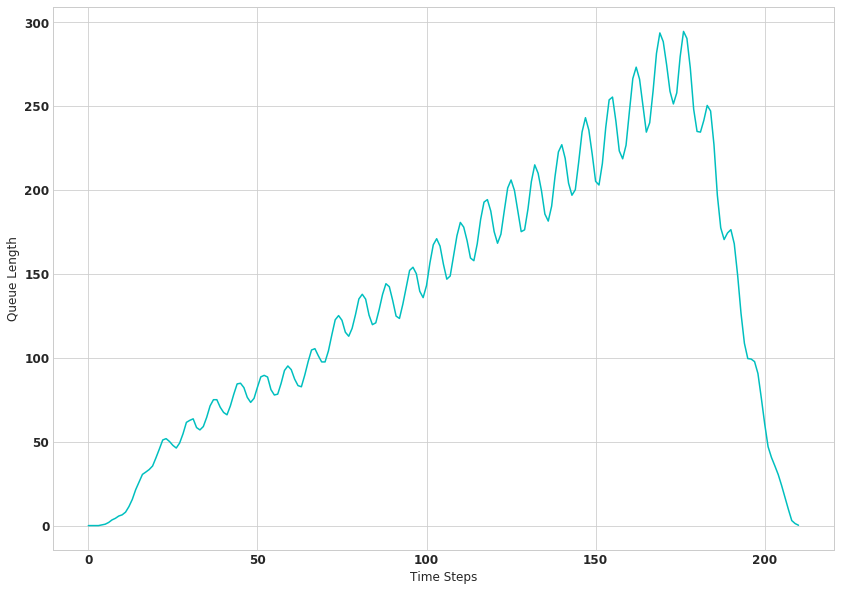

In [18]:

#Testing if simulation works (with fixed time)

sumoBinary = 'sumo-gui'

options = ["--time-to-teleport","-1","--statistic-output","stats.xml", "--eager-insert","True", \
           "--tripinfo-output","env/intersection_3_info.xml","--summary-output","summary.xml",\
           "--tripinfo-output.write-unfinished","True"]
sumoCmd = [sumoBinary,"-c","env/intersection_3.sumocfg",*options]

intersection = 'intersection'

queue, average_TT, durations = test_performence(agent='fixed', state_type='queue', n_cars=4001,\
                                          render=True, n_tests=1,time=3800, max_pos=250, dist='weibull',\
                                          both=False, ig_far_cars=False, verbose=0, green_duration=green_duration)   




print('Average Travel Time:', np.squeeze(average_TT))
plot_and_save(queue, 'None', 'Queue Length', save=False, save_data=False,\
              x_label='Time Steps', smoothing=True, smoothing_window=10)

In [15]:
action_size = 4
state_size = 16 + action_size

# DQN Agent
class DQNAgent:
    '''
    Double-DQN Agent with Target Network and Prioritized Experience Replay
    --Network Structure: Multi Layer Perceptron
    '''
    def __init__(self, state_size, action_size, batch_n, dropout,\
                 num_layers=3, hidden_neurons=128, lr=0.001, per=False):
        
        #Input Vector Size
        self.state_size = state_size
        # Number of outputs (Q-Vaules of actions (Phases))
        self.action_size = action_size
        
        #Prioritized Experience Replay Memory
        if per:
            self.memory = Memory(40000) #PER
        else:
            self.memory = deque(maxlen=40000)
        # Discount Factor for Q-learning
        self.gamma = 0.95
        self.per = per
        #Epsilon Settings
        self.epsilon = 1.0
        self.epsilon_decay = 0.9750
        self.epsilon_min = 0.02
        # Learning rate for Network Learning
        self.learning_rate = lr
        
        self.batch_n = batch_n
        self.dropout = dropout
        # Main Q-Network 
        self.model = self._build_model(in_size=self.state_size, act_size=self.action_size, \
                           num_layers=num_layers, hidden_neurons=hidden_neurons, batch_n=batch_n, dropout=dropout)
        
        #Traget Q-Network  
        self.target_model = self._build_model(in_size=self.state_size, act_size=self.action_size, \
                           num_layers=num_layers, hidden_neurons=hidden_neurons, batch_n=batch_n, dropout=dropout)
        self.target_model.set_weights(self.model.get_weights())      
        self.update_couter = 0
        
    
    def _build_model(self, in_size, act_size, num_layers=2, \
                     hidden_neurons=64, batch_n=False, dropout=False ):
        ''' Model Builder with different paramters
            Multi Layer Perceptron Architecture
        '''
        model = Sequential()
        for layer in range(num_layers):
            model.add(Dense(hidden_neurons, input_dim = in_size))
            if batch_n:
                model.add(BatchNormalization())
            if dropout:
                model.add(Dropout(0.2))
            model.add(Activation(activation='relu'))
#           
        
        model.add(Dense(act_size, activation='linear'))
        #RSMProp Optimizer
        model.compile(loss = 'mse', optimizer=RMSprop(lr=self.learning_rate) ,metrics = ['accuracy']) #Adam(lr=self.learning_rate)
        
        return model
    
    
    

#PER 
    
    def remember(self, state, action, reward, next_state, done):
        '''
        Store Agent Experiences in Tuples of (state, action, reward, next_state, done)
        
        '''    
        #If PER is True: Compute TD_error before storing the Experiences
        if self.per:
            if done:
                target = reward
            else:
                
                p_ = self.model.predict(next_state)[0]
                pTarget_ = self.target_model.predict(next_state)[0]
                target = reward + self.gamma*pTarget_[np.argmax(p_)]

            td_error = abs(target - self.model.predict(state)[0][action])

            self.memory.add(td_error, (state, action, reward, next_state, done))
            
        #Else if not PER, Store the Experiences immediately
        else:
            self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        '''
            epsilon-greedy action policy
        '''
        if np.random.rand()<self.epsilon:
            action = random.randrange(self.action_size)
            return action
        
        else:
            act_values = self.model.predict(state)
            action = np.argmax(act_values[0])
            return action
    
    def replay(self, batch_size, update_tn_each = 5):
        '''
        Replay Batch of the stored Experiences and Train the Agent on them 
        '''
        if self.per:
            minibatch, idx, is_weight = self.memory.sample(batch_size)#PER
        else:
            minibatch = random.sample(self.memory, batch_size)
            
            
        for i in range(batch_size):

            state, action, reward, next_state, done = minibatch[i]
            
#         for state, action, reward, next_state in minibatch:
            if done:
                target = reward
            else:

                max_action = np.argmax(self.model.predict(next_state))
                target = (reward + self.gamma*self.target_model.predict(next_state)[0][max_action])
            
#             target = (reward + self.gamma*np.amax(self.target_model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            
            if self.per:
                
                self.model.fit(state, target_f, epochs=1, verbose = 0, sample_weight=np.array([is_weight[i]])) #PER
            else:
                self.model.fit(state, target_f, epochs=1, verbose = 0)
            
        self.update_couter+=1
        
        if self.update_couter % update_tn_each == 0:
            self.update_target()
    
    def update_target(self):
        self.target_model.set_weights(self.model.get_weights()) 
        
        
    def update_epsilon(self):
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def load(self, name):
        self.model.load_weights(name)
        
    def save(self, name):
        self.model.save(name)

In [16]:
# create agent instance:

action_size = 4
state_size = 16 + 1
agent = DQNAgent(state_size=state_size, action_size=4, hidden_neurons=64, num_layers=3, dropout=False,lr=0.001, batch_n=False, per=True)
agent.model.summary()
agent.epsilon = 1







_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1152      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_3 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 260       
Tota

In [15]:
output_dir = 'tls_model/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
test_dir =  os.path.join(output_dir,'test_results')
if not os.path.exists(test_dir):
    os.makedirs(test_dir)


In [ ]:
# Training 
###
batch_size = 32
AGGREGATE_STATS_EVERY = 50 
###
green_durations = [15]#, 15, 20 , 30]
flows_list = ['weibull']#,'normal']
n_cars_list = [4001]#, 4001]#, ]#, 9600]
state_list = ['n_of_vehicles']#,'queue', 'n_of_vehicles']
penalty_list = [False, 'ep_reward', 'teleport']
max_pos = 150
n_of_experiments = 1
n_episodes  = 501
####
for experiment in range(n_of_experiments):
    for flow_type in flows_list:
        
        #Initialize agent
        agent = DQNAgent(state_size=state_size, action_size=4, hidden_neurons=64,\
                         num_layers=3, dropout=False,lr=0.001, batch_n=False, per=True)
        agent.epsilon = 1.
        
        #agent Params
        agent.epsilon_decay =0.9914
        
#       Initialization

        reward_list = []
        queue_list  = []
        travel_time_list = []
        waiting_time_list = []
        
        AGGREGATE_REWARD_EVERY = 50
        start_learning = False
        save_label = time.ctime()
        final_time = 3800
        model_path = os.path.join(output_dir, save_label)

        if not os.path.exists(model_path):
            os.makedirs(model_path)
            
        #sumo cmd simulation settings
        
        sumoBinary = 'sumo'
        options = ["--time-to-teleport","-1","--statistic-output","stats.xml", "--eager-insert","True", \
           "--tripinfo-output","env/intersection_3_info.xml","--summary-output","summary.xml",\
           "--tripinfo-output.write-unfinished","False"]
        sumoCmd = [sumoBinary,"-c","env/intersection_3.sumocfg",*options]

        #random_selection of flow type
#         flow_n = np.random.choice(range(len(flows_list))) 
#         flow_type = flows_list[flow_n]
        #random_selection of number of cars
        n_cars_n = np.random.choice(range(len(n_cars_list)))
        n_cars = n_cars_list[n_cars_n]

        #random_selection of number of green duration
        green_dur_n = np.random.choice(range(len(green_durations)))
        green_duration = green_durations[green_dur_n]

        #random_selection of state_type
        state_n = np.random.choice(range(len(state_list)))
        state_type = state_list[state_n]
#         state_type = 'queue'
        #random_selection of number of state_type
        penalty_n = np.random.choice(range(len(penalty_list)))
        penalty_type = penalty_list[penalty_n]
        
        penalty_type = penalty_list[experiment]             ###
        if penalty_type =='teleport':
            del sumoCmd[3:5]

        #fix penalty and green duration at moment
#         penalty_type = False
        if n_cars == 1500:
            green_duration = 15
        elif n_cars == 4000:
            green_duration = 15
        else:
            green_duration = 15

        #Penlaty threshold:
        if state_type == 'n_of_vehicles':
            penalty_thresh = -20000
        elif state_type == 'queue':
            penalty_thresh = -15000
        else:
            penalty_thresh = -300000




        print('-------------- Setup Training with the Next Parameters --------------')
        print('Flow Type:                    |', flow_type)
        print('Number of cars generated:     |', n_cars)
        print('Green Phase duration:         |', green_duration)
        print('State and Reward Definition:  |', state_type)
        print('Penalty Type:                 |', penalty_type)
        print('Penalty THresh:               |', penalty_thresh)



        print('--------------                                        ---------------')
        for j,episode in enumerate(range(n_episodes)):

            generate_route_file(dist = flow_type, n_cars=n_cars, episode=episode) 
            episode_reward = 0

            traci.start(sumoCmd)
            intersection = 'intersection'

            traci.simulationStep()
            step = 0
            old_action = random_action()


            set_green_phase(old_action, green_duration=green_duration)
            #assign:

            state = get_state(intersection, max_pos=max_pos, state_type=state_type, ignore_far_cars=False)
            state = np.reshape(state, [1, state_size])

            counter = 0
            reward_track = deque(maxlen=5)
            ep_queue_list = []
            done = False
            teleported_number = 0
            while step<=final_time:



                old_reward = np.sum(state[0][0:-1])
                action = agent.act(state)


                if action != old_action:
                    set_yellow_phase(old_action)

                set_green_phase(action, green_duration=green_duration)
                step = step + yellow_duration + green_duration


                queue = get_queue(intersection)

                next_state = get_state(intersection, state_type=state_type, max_pos=max_pos, ignore_far_cars=False)
                next_state = np.reshape(next_state, [1, state_size])
                



                new_reward = np.sum(next_state[0][0:-1])

                reward = - new_reward
                episode_reward += reward
                ep_queue_list.append(queue)


                next_step = step + yellow_duration + green_duration

                if next_step >= final_time:
                    done = True
                if done:
                    agent.remember(state, action, reward, next_state, done)
                    break


                reward_track.append((state, action, reward, next_state, done))

                if penalty_type == 'teleport':

                    teleports = traci.simulation.getStartingTeleportNumber()
                    teleported_number += teleports

                    if teleports>0:
                        print('t:',teleported_number,'step:',step)
                        reward = penalty_thresh / 10
                        done = True
                        agent.remember(state, action, reward, next_state, done)
                        for i,tup in enumerate(reward_track):
                            agent.remember(tup[0], tup[1], -i*(reward/10)+reward ,tup[3], tup[4])


                        break

                elif penalty_type == 'ep_reward':
                    if episode_reward< penalty_thresh:
                        reward = penalty_thresh/8
                        done = True
                        agent.remember(state, action, reward, next_state, done)
                        for i,tup in enumerate(reward_track):
                            agent.remember(tup[0], tup[1], -i*(reward/10)+reward ,tup[3], tup[4])

                        print(step)
                        break


                agent.remember(state, action, reward, next_state, done)
                reward_track.append((state, action, reward, next_state, done))

                old_action = action
                state = next_state




            #for each episode
            

            if episode>4:
                start_learning = True
                for _ in range(3):
                    agent.replay(batch_size)
                agent.update_epsilon()
                
    
            reward_list.append(episode_reward)
            queue_list.append(sum(ep_queue_list)/len(ep_queue_list))

            average_reward = sum(reward_list[-AGGREGATE_REWARD_EVERY:])/len(reward_list[-AGGREGATE_REWARD_EVERY:])

            average_queue = sum(queue_list[-AGGREGATE_REWARD_EVERY:])/len(queue_list[-AGGREGATE_REWARD_EVERY:])

            try:
                durations = np.asarray(get_from_info(file_path='env/intersection_3_info.xml'), dtype=np.float32)
                average_travel_time = np.sum(durations)/len(durations)
                travel_time_list.append(average_travel_time)
                
                waiting_times = np.asarray(get_from_info(file_path='env/intersection_3_info.xml',\
                                                         retrieve='waitingTime'), dtype=np.float32)
                avg_waiting = np.sum(waiting_times)/len(waiting_times)  
                print('avg waiting time: ',avg_waiting)
                waiting_time_list.append(avg_waiting)
                
            except:
                print('travel time skipped')

            max_reward = max(reward_list[-AGGREGATE_REWARD_EVERY:])
            min_reward = min(reward_list[-AGGREGATE_REWARD_EVERY:])

            #Save and plot
            if episode % AGGREGATE_REWARD_EVERY == 0 and episode!=0:
                agent.save(model_path +'/'+'tnet'+'state_in_out'+ '{:04d}'.format(episode) + '.hdf5')
                if episode+1 == n_episodes:
                    file_to_store = open(model_path +'/'+'agent'+ '{:04d}'.format(episode) + '.pickle', "wb")
                    pickle.dump(agent, file_to_store)
                    file_to_store.close()

                plot_and_save(reward_list, model_path, 'reward', episode=episode)


                plot_and_save(queue_list, model_path, 'queue', episode=episode)


                plot_and_save(travel_time_list, model_path, 'avg_travel_time', episode=episode)
                
                plot_and_save(waiting_time_list, model_path, 'avg_waiting_time', episode=episode)

    #         print('episode : {}/{}, episode_reward {}, avg_queu {}, e={:.2}'.format(episode, n_episodes, episode_reward, average_queue, agent.epsilon))

            try:
                
                durations = np.asarray(get_from_info(), dtype=np.float32)
                avg_duration = np.sum(durations)/len(durations)    
                print('episode :{}/{}, episode_reward {}, avg_queu {}, e={:.2}, avg_time:{}'.format(episode, n_episodes, episode_reward, \
                                                                                                    average_queue, agent.epsilon,avg_duration))
            except:
                print('info file error')

            traci.close()

        average_travel_time = sum(travel_time_list[-AGGREGATE_REWARD_EVERY:])\
        /len(travel_time_list[-AGGREGATE_REWARD_EVERY:])
        print('avg travel time:{}'.format(average_travel_time))
        
        # Testing Performance

        rs, qs, avg_dur, durations = test_performence(agent=agent, state_type=state_type, n_cars=n_cars,\
                                                  render=False, n_tests=15,time=3800, max_pos=250,\
                                                  both=False, ig_far_cars=False, verbose=0, green_duration=green_duration)    

        print('mean avg travel time:{}'.format(np.mean(avg_dur)))
        # Plotting test results
        plot_and_save(rs[-1], model_path, 'test_reward', save=True, smoothing=True, smoothing_window=10)
        plot_and_save(qs[-1], model_path, 'test_queue', save=True, smoothing=True, smoothing_window=10)
        plot_and_save(durations, model_path, 'test_travel_time', save=True, smoothing=True, smoothing_window=10)





In [20]:
# # Example if loading a saved agent --> uncomment

# from keras.models import load_model
# agent = DQNAgent(state_size=state_size, action_size=4, hidden_neurons=64, num_layers=3, dropout=False,lr=0.001, batch_n=False, per=True)
# model_path = 'tls_model/weibull_4000_15_n_veh_150__No_penalty/'
# agent.model   = load_model(model_path+ 'tnetstate_in_out0500.hdf5')
# agent.epsilon = 0

In [18]:
state_type = 'n_of_vehicles'
green_duration =15
flow_type = 'weibull'
n_cars = 4001


In [ ]:
#Test fixed and Actuated agents

# results = test_performence(agent='fixed', state_type=state_type, n_cars=n_cars,\
#                                           render=False, n_tests=1,time=3800, max_pos=250, dist=flow_type,\
#                                           both=False, ig_far_cars=False, verbose=0, green_duration=green_duration)   

# print('mean avg travel time:{}'.format(np.mean(results[2])))
# # Plotting test results
# plot_and_save(results[2], model_path, 'test_reward_', save=False, smoothing=True, smoothing_window=10)
# plot_and_save(results[0], model_path, 'test_queue_', save=False, smoothing=True, smoothing_window=10)
# plot_and_save(durations, model_path, 'test_travel_time', save=False, smoothing=True, smoothing_window=10)

rs, qs, avg_dur, durations = test_performence(agent=agent, state_type=state_type, state_size=state_size,\
                                              n_cars=n_cars, episode=11,\
                                          render=False, n_tests=2,time=3800, max_pos=150, dist=flow_type,\
                                          both=False, ig_far_cars=False, verbose=0, green_duration=green_duration)   

# print('mean avg travel time:{}'.format(np.mean(avg_dur)))
# Plotting test results
plot_and_save(rs[-1], model_path, 'test_reward_2', save=True, smoothing=True, smoothing_window=10)
plot_and_save(qs[-1], model_path, 'test_queue_2', save=True, smoothing=True, smoothing_window=10)
plot_and_save(durations, model_path, 'test_travel_time_2', save=True, smoothing=True, smoothing_window=10)


In [ ]:
#Testing the agent on random episodes

state_type = 'n_of_vehicles'
green_duration =15
flow_type = 'weibull'
n_cars = 4001







#Random episodes
rand_eps = [ 70, 950, 495, 823, 113, 148, 732, 876, 518, 517]
res = {}

from keras.models import load_model



for i in range(0,1):
    print('->>>>>>>', agent_type)
    agent = DQNAgent(state_size=state_size, action_size=4, hidden_neurons=64, num_layers=3, dropout=False,lr=0.001, batch_n=False, per=True)
    agent.epsilon = 0
    agent.model   = load_model('tls_model/'+'selected/'+ agent_type+ '/tnetstate_in_out0500.hdf5')
    avgerage_time = []
    for i in rand_eps:

        rs, qs, avg_dur, durations = test_performence(agent=agent, state_type=state_type, state_size=state_size,\
                                                      n_cars=n_cars, episode=i,\
                                              render=False, n_tests=1, time=3800, max_pos=150, dist=flow_type,\
                                              both=False, ig_far_cars=False, verbose=0, green_duration=green_duration)
        avgerage_time.append(avg_dur)
    res[agent_type] = avgerage_time
    print('mean avg travel time:{}'.format(np.mean(avgerage_time)))

#     Plotting test results
plot_and_save(rs[-1], model_path, 'test_reward', save=False, smoothing=True, smoothing_window=10)
plot_and_save(qs[-1], model_path, 'test_queue', save=False, smoothing=True, smoothing_window=10)
plot_and_save(durations, model_path, 'test_travel_time', save=False, smoothing=True, smoothing_window=10)


In [ ]:
from keras.models import load_model
state_size = 17
flow_type = 'weibull'
state_type = 'queue'
n_cars = 4001
agent = DQNAgent(state_size=state_size, action_size=4, hidden_neurons=64, num_layers=3, dropout=False,lr=0.001, batch_n=False, per=True)
model_path = 'tls_model/selected/q_s_-_q_reward_penalty_143_penalty__no-ignoring'
agent.model   = load_model(model_path+ '/tnetstate_in_out0400.hdf5')
agent.epsilon = 0



In [ ]:
rs, qs, avg_dur, durations = test_performence(agent=agent, state_type=state_type, state_size=state_size,\
                                              n_cars=n_cars, episode=11,\
                                          render=False, n_tests=1,time=3800, max_pos=150, dist=flow_type,\
                                          both=False, ig_far_cars=False, verbose=0, green_duration=green_duration)   

# print('mean avg travel time:{}'.format(np.mean(avg_dur)))
# Plotting test results
plot_and_save(rs[-1], model_path, 'test_reward', save=True, smoothing=True, smoothing_window=10)
plot_and_save(qs[-1], model_path, 'test_queue', save=True, smoothing=True, smoothing_window=10)
plot_and_save(durations, model_path, 'test_travel_time', save=True, smoothing=True, smoothing_window=10)

